In [1]:
import torch
from transformers import AutoConfig, AutoImageProcessor, AutoModelForVision2Seq, AutoProcessor
import time
import numpy as np
import cv2
import textwrap
from PIL import Image, ImageDraw, ImageFont
import enum



/home/zhekai/miniforge3/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-04 14:12:39.426399: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 14:12:39.452701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 14:12:39.452722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 14:

In [2]:
#Define some utils.

def split_reasoning(text, tags):
    new_parts = {None: text}

    for tag in tags:
        parts = new_parts
        new_parts = dict()

        for k, v in parts.items():
            if tag in v:
                s = v.split(tag)
                new_parts[k] = s[0]
                new_parts[tag] = s[1]
                # print(tag, s)
            else:
                new_parts[k] = v

    return new_parts

class CotTag(enum.Enum):
    TASK = "TASK:"
    PLAN = "PLAN:"
    VISIBLE_OBJECTS = "VISIBLE OBJECTS:"
    SUBTASK_REASONING = "SUBTASK REASONING:"
    SUBTASK = "SUBTASK:"
    MOVE_REASONING = "MOVE REASONING:"
    MOVE = "MOVE:"
    GRIPPER_POSITION = "GRIPPER POSITION:"
    ACTION = "ACTION:"


def get_cot_tags_list():
    return [
        CotTag.TASK.value,
        CotTag.PLAN.value,
        CotTag.VISIBLE_OBJECTS.value,
        CotTag.SUBTASK_REASONING.value,
        CotTag.SUBTASK.value,
        CotTag.MOVE_REASONING.value,
        CotTag.MOVE.value,
        CotTag.GRIPPER_POSITION.value,
        CotTag.ACTION.value,
    ]

def name_to_random_color(name):
    return [(hash(name) // (256**i)) % 256 for i in range(3)]


def draw_gripper(img, pos_list, img_size=(640, 480)):
    for i, pos in enumerate(reversed(pos_list)):
        pos = resize_pos(pos, img_size)
        scale = 255 - int(255 * i / len(pos_list))
        cv2.circle(img, pos, 6, (0, 0, 0), -1)
        cv2.circle(img, pos, 5, (scale, scale, 255), -1)

def get_metadata(reasoning):
    metadata = {"gripper": [[0, 0]], "bboxes": dict()}

    if f" {CotTag.GRIPPER_POSITION.value}" in reasoning:
        gripper_pos = reasoning[f" {CotTag.GRIPPER_POSITION.value}"]
        gripper_pos = gripper_pos.split("[")[-1]
        gripper_pos = gripper_pos.split("]")[0]
        gripper_pos = [int(x) for x in gripper_pos.split(",")]
        gripper_pos = [(gripper_pos[2 * i], gripper_pos[2 * i + 1]) for i in range(len(gripper_pos) // 2)]
        metadata["gripper"] = gripper_pos

    if f" {CotTag.VISIBLE_OBJECTS.value}" in reasoning:
        for sample in reasoning[f" {CotTag.VISIBLE_OBJECTS.value}"].split("]"):
            obj = sample.split("[")[0]
            if obj == "":
                continue
            coords = [int(n) for n in sample.split("[")[-1].split(",")]
            metadata["bboxes"][obj] = coords

    return metadata

def resize_pos(pos, img_size):
    return [(x * size) // 256 for x, size in zip(pos, img_size)]

def draw_bboxes(img, bboxes, img_size=(640, 480)):
    for name, bbox in bboxes.items():
        show_name = name
        # show_name = f'{name}; {str(bbox)}'

        cv2.rectangle(
            img,
            resize_pos((bbox[0], bbox[1]), img_size),
            resize_pos((bbox[2], bbox[3]), img_size),
            name_to_random_color(name),
            1,
        )
        cv2.putText(
            img,
            show_name,
            resize_pos((bbox[0], bbox[1] + 6), img_size),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            1,
            cv2.LINE_AA,
        )

In [3]:
device = "cuda:0"
# Load Processor & VLA
path_to_converted_ckpt = "Embodied-CoT/ecot-openvla-7b-bridge"
processor = AutoProcessor.from_pretrained(path_to_converted_ckpt, trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    path_to_converted_ckpt,
    attn_implementation="flash_attention_2",  # [Optional] Requires `flash_attn`
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).to(device)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Expected `transformers==4.40.1` and `tokenizers==0.19.1` but got `transformers==4.46.1` and `tokenizers==0.20.1`; there might be inference-time regressions due to dependency changes. If in doubt, pleaseuse the above versions.
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


In [4]:
SYSTEM_PROMPT = (
    "A chat between a curious user and an artificial intelligence assistant. "
    "The assistant gives helpful, detailed, and polite answers to the user's questions."
)

def get_openvla_prompt(instruction: str) -> str:
    return f"{SYSTEM_PROMPT} USER: What action should the robot take to {instruction.lower()}? ASSISTANT: TASK:"

INSTRUCTION = "place the watermelon on the towel"
prompt = get_openvla_prompt(INSTRUCTION)
image = Image.open("./test_obs.png")
print(prompt.replace(". ", ".\n"))

A chat between a curious user and an artificial intelligence assistant.
The assistant gives helpful, detailed, and polite answers to the user's questions.
USER: What action should the robot take to place the watermelon on the towel? ASSISTANT: TASK:


In [5]:
from torch.profiler import profile, record_function, ProfilerActivity

# === BFLOAT16 MODE ===
inputs = processor(prompt, image).to(device, dtype=torch.bfloat16)
# inputs["input_ids"] = inputs["input_ids"][:, 1:]

# Run OpenVLA Inference
start_time = time.time()
torch.manual_seed(0)

def trace_handler(prof):
    # print(prof.key_averages().table(
    #     sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("tmp/test_trace_" + str(prof.step_num) + ".json")

# with torch.profiler.profile(
#     activities=[
#         torch.profiler.ProfilerActivity.CPU,
#         torch.profiler.ProfilerActivity.CUDA,
#     ],
#     schedule=torch.profiler.schedule(
#         wait=1,
#         warmup=1,
#         active=1),
#     on_trace_ready=trace_handler,
#     with_stack=True,
#     profile_memory=True,
#     with_flops = True
#     ) as p:
#         for iter in range(3):
#             # torch.square(torch.randn(10000, 10000).cuda())
#             action, generated_ids = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False, max_new_tokens=1024)
#             p.step()
#             # send a signal to the profiler that the next iteration has started
            
# generated_text = processor.batch_decode(generated_ids)[0]
# print(f"Time: {time.time() - start_time:.4f} || Action: {action}")


In [6]:
#torch cuda event
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
times = []
for i in range(10):
    start.record()
    action, generated_ids = vla.predict_action(**inputs, unnorm_key="bridge_orig", do_sample=False, max_new_tokens=1024)
    end.record()
    torch.cuda.synchronize()
    times.append(start.elapsed_time(end))
print("Average inference time: ", sum(times)/len(times))
print("Std: ", torch.tensor(times).std().item())





We detected that you are passing `past_key_values` as a tuple of tuples. This is deprecated and will be removed in v4.47. Please convert your cache or use an appropriate `Cache` class (https://huggingface.co/docs/transformers/kv_cache#legacy-cache-format)


Average inference time:  5598.185107421875
Std:  92.57414245605469


In [7]:
#profile memroy with torch
generated_text = processor.batch_decode(generated_ids)[0]
print(torch.cuda.memory_summary(device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  13730 MiB |  14371 MiB |    793 GiB |    780 GiB |
|       from large pool |  13728 MiB |  14368 MiB |    751 GiB |    737 GiB |
|       from small pool |      2 MiB |      5 MiB |     42 GiB |     42 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  13730 MiB |  14371 MiB |    793 GiB |    780 GiB |
|       from large pool |  13728 MiB |  14368 MiB |    751 GiB |

In [8]:
tags = [f" {tag}" for tag in get_cot_tags_list()]
reasoning = split_reasoning(generated_text, tags)
text = [tag + reasoning[tag] for tag in [' TASK:',' PLAN:',' SUBTASK REASONING:',' SUBTASK:',
                                        ' MOVE REASONING:',' MOVE:', ' VISIBLE OBJECTS:', ' GRIPPER POSITION:'] if tag in reasoning]
metadata = get_metadata(reasoning)
bboxes = {}
for k, v in metadata["bboxes"].items():
    if k[0] == ",":
        k = k[1:]
    bboxes[k.lstrip().rstrip()] = v

caption = ""
for t in text:
    wrapper = textwrap.TextWrapper(width=80, replace_whitespace=False) 
    word_list = wrapper.wrap(text=t) 
    caption_new = ''
    for ii in word_list[:-1]:
        caption_new = caption_new + ii + '\n      '
    caption_new += word_list[-1]

    caption += caption_new.lstrip() + "\n\n"

base = Image.fromarray(np.ones((480, 640, 3), dtype=np.uint8) * 255)
draw = ImageDraw.Draw(base)
font = ImageFont.load_default(size=14) # big text
color = (0,0,0) # RGB
draw.text((30, 30), caption, color, font=font)

img_arr = np.array(image)
draw_gripper(img_arr, metadata["gripper"])
draw_bboxes(img_arr, bboxes)

text_arr = np.array(base)

reasoning_img = Image.fromarray(np.concatenate([img_arr, text_arr], axis=1))

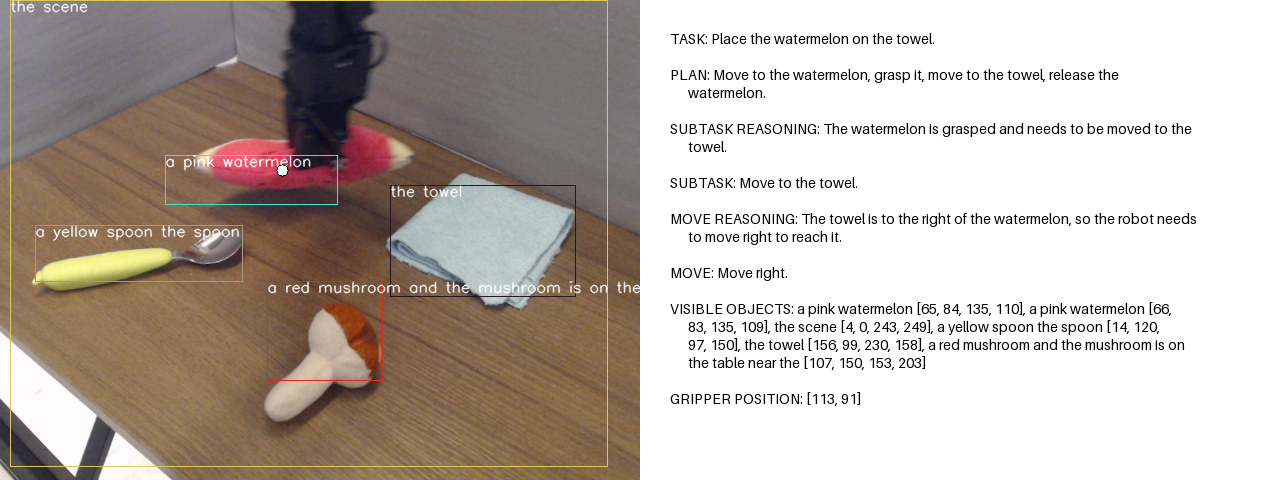

In [9]:
reasoning_img

In [10]:
action

array([ 0.01321167, -0.03668522,  0.00027841, -0.0205739 , -0.02891492,
       -0.08065662,  0.        ])